# PPK

This python script aims to apply the PPK using the **RTKLIB** package an Open Source Program Package for GNSS Positioning.

Package Requirements: 

- RTKLIB Package.
- pandas.
- matplotlib.

## Importing Packages

In [1]:
import os, sys,subprocess,csv
import math
import datetime, time
import pandas as pd
from datetime import datetime

## Specify directories, PPK configuration file.

In [2]:
rover_files='C:/Users/bourriz/GNSS-Correction-RTKLIB-master/UIS_PosPac_HyspexNav_processing/Result/Rover/' #Path of the rover files
rnx2rtkp='C:/Users/bourriz/GNSS-Correction-RTKLIB-master/UIS_PosPac_HyspexNav_processing/demo5_b34g/rnx2rtkp' #Path of the rnx2rtkp tool for ppk correction
ppkconf='C:/Users/bourriz/GNSS-Correction-RTKLIB-master/UIS_PosPac_HyspexNav_processing/PPK_conf/ppk_2.conf' #Path of the ppk config file
corrections='C:/Users/bourriz/GNSS-Correction-RTKLIB-master/UIS_PosPac_HyspexNav_processing/Result/Corrections_files/'#Path of the correction files
Result='C:/Users/bourriz/GNSS-Correction-RTKLIB-master/UIS_PosPac_HyspexNav_processing/Result/' #Path of result
observation_path='C:/Users/bourriz/GNSS-Correction-RTKLIB-master/UIS_PosPac_HyspexNav_processing/Result/Rover/5905C00224202112030934-5905C00224202112031022.obs'
navigation_path='C:/Users/bourriz/GNSS-Correction-RTKLIB-master/UIS_PosPac_HyspexNav_processing/Result/Rover/5905C00224202112030934-5905C00224202112031022.nav'
for file in os.listdir(corrections):
 Permanent_obs_path=os.path.join(corrections,'WIND00NAM_R_20213370000_01D_30S_MO.obs') #Path of the observation file of the permanent station
 Permanent_nav_path=os.path.join(corrections,'brdc3370.21n') #path of the navigation file of the permanent station
 Orbital_file_path=os.path.join(corrections,'igs21865.sp3') #path of the orbital file

In [3]:
#Create directory of result if does not exist
Position=Result+'Position/'
if not os.path.exists(Position):
   os.mkdir(Position)
else:
   print(f'{Position} is already created')

C:/Users/bourriz/GNSS-Correction-RTKLIB-master/UIS_PosPac_HyspexNav_processing/Result/Position/ is already created


In [4]:
#Apply the PPK correction using rnx2rtkp tool
for name in os.listdir(rover_files):
    if name.endswith('.obs'):
     pos_out=Position + name.split('.obs')[0]+'.pos'#Path of the position file
if not os.path.exists(pos_out):
      cmd=rnx2rtkp + ' -k '+ppkconf+' -o '+pos_out+\
     ' '+ observation_path + ' ' + Permanent_obs_path + ' ' + Permanent_nav_path + ' ' + navigation_path +  ' ' + Orbital_file_path + ' '
      cmd=cmd.replace('/','\\')
      subprocess.call(cmd, shell=False)
      print('Process Done')
else:
    print('The .pos file already exist')

The .pos file already exist


The output of *rnx2rtkp* is a list of coordinate with a specific extension **.pos** readable using NotePad++.
For manipulation, it's better to convert it into **.csv**

In [5]:
Processed_position=pos_out #path of the output
gnss_data=pd.read_csv(Processed_position,sep='\s+',header=None,comment='%')
gnss_data.columns = [
        'GPST','Timestamp', 'Latitude', 'Longitude', 'Height', 'Q', 'ns',
        'sdn(m)', 'sde(m)', 'sdu(m)', 'sdne(m)', 'sdeu(m)', 'sdun(m)', 'age(s)', 'ratio',
        'vn(m/s)', 've(m/s)', 'vu(m/s)', 'sdvn', 'sdve', 'sdvu', 'sdvne', 'sdveu', 'sdvun'
    ]
gnss_data.head(5)

,GPST,Timestamp,Latitude,Longitude,Height,Q,ns,sdn(m),sde(m),sdu(m),...,ratio,vn(m/s),ve(m/s),vu(m/s),sdvn,sdve,sdvu,sdvne,sdveu,sdvun
0,2186,466543.4,-21.241363,14.876887,901.7170,4,3,4.0148,7.7656,25.4229,...,1.4,-1.03204,1.91748,0.08522,2.26644,3.64198,10.23567,-2.12832,-5.63846,4.05694
1,2186,466543.6,-21.241365,14.876892,901.7332,4,3,3.7037,7.1768,23.5275,...,1.4,-0.33353,0.53270,0.02729,2.10978,3.38555,9.78956,-2.09458,-5.39471,3.87928
2,2186,466544.2,-21.241366,14.876893,901.7352,4,3,2.9174,5.6605,18.5672,...,1.4,0.01021,-0.04879,0.00073,1.38262,2.62462,8.48690,-1.85061,-4.68343,3.36569
3,2186,466544.4,-21.241366,14.876893,901.7354,4,3,2.6713,5.1838,17.0026,...,1.4,0.02707,-0.00883,0.00085,1.31835,2.49828,8.06588,-1.75813,-4.45124,3.19850
4,2186,466544.6,-21.241366,14.876893,901.7355,4,3,2.4379,4.7316,15.5182,...,1.4,-0.00599,0.04072,0.00218,1.25539,2.37423,7.65196,-1.66718,-4.22295,3.03414


In [6]:
gnss_data.to_csv('C:/Users/bourriz/GNSS-Correction-RTKLIB-master/UIS_PosPac_HyspexNav_processing/Result/Position/gnss_data.csv',index=False)

After the conversion, we can now manipulate the data using Pandas.

In [7]:
gnssWeek=gnss_data['GPST'].to_list()
SOW=gnss_data['Timestamp'].to_list()
len(SOW)

26964

We need to convert the GPS time to UTC time (ISO Format) for a later use.

In [8]:
#Converting GPST to UTC
secsInWeek = 604800
secsInDay = 86400
gnssEpoch = (1980, 1, 6, 0, 0, 0)  # (year, month, day, hh, mm, ss)
leapSecs=18
UTC_time=[]
for i in range(len(gnssWeek)):
 secFract = SOW[i] % 1
 epochTuple = gnssEpoch + (-1, -1, 0)
 # mktime is localtime, correct for UTC 145
 t0 = time.mktime(epochTuple) - time.timezone
 tdiff = (gnssWeek[i] * secsInWeek) + SOW[i] - leapSecs
 t = t0 + tdiff
 (year, month, day, hh, mm, ss, dayOfWeek,
 julianDay, daylightsaving) = time.gmtime(t)
 UTC=(year,month,day,hh,mm,round(ss))
 time_utc=datetime(*UTC)
 time_str = time_utc.strftime("%Y-%m-%d %H:%M:%S")
 UTC_time.append(time_str)

In [9]:
#Adding UTC to the dataframe
gnss_data.insert(2, 'UTC_Time', UTC_time)

In [10]:
gnss_data.head()

,GPST,Timestamp,UTC_Time,Latitude,Longitude,Height,Q,ns,sdn(m),sde(m),...,ratio,vn(m/s),ve(m/s),vu(m/s),sdvn,sdve,sdvu,sdvne,sdveu,sdvun
0,2186,466543.4,2021-12-03 09:35:25,-21.241363,14.876887,901.7170,4,3,4.0148,7.7656,...,1.4,-1.03204,1.91748,0.08522,2.26644,3.64198,10.23567,-2.12832,-5.63846,4.05694
1,2186,466543.6,2021-12-03 09:35:25,-21.241365,14.876892,901.7332,4,3,3.7037,7.1768,...,1.4,-0.33353,0.53270,0.02729,2.10978,3.38555,9.78956,-2.09458,-5.39471,3.87928
2,2186,466544.2,2021-12-03 09:35:26,-21.241366,14.876893,901.7352,4,3,2.9174,5.6605,...,1.4,0.01021,-0.04879,0.00073,1.38262,2.62462,8.48690,-1.85061,-4.68343,3.36569
3,2186,466544.4,2021-12-03 09:35:26,-21.241366,14.876893,901.7354,4,3,2.6713,5.1838,...,1.4,0.02707,-0.00883,0.00085,1.31835,2.49828,8.06588,-1.75813,-4.45124,3.19850
4,2186,466544.6,2021-12-03 09:35:26,-21.241366,14.876893,901.7355,4,3,2.4379,4.7316,...,1.4,-0.00599,0.04072,0.00218,1.25539,2.37423,7.65196,-1.66718,-4.22295,3.03414


In [11]:
#Save the dataframe to a Csv file
gnss_data.to_csv('C:/Users/bourriz/GNSS-Correction-RTKLIB-master/UIS_PosPac_HyspexNav_processing/Result/Position/gnss_data.csv',index=False)

# Calculation of GDOP

The main idea is to analyze drone positioning data by estimating its accuracy,the **GDOP** value (*Indicator of the accuracy*) of the drone can be calculated.

## Importing the necessary modules and packages

In [12]:
import os
from Modules.calc_manager import Calc_manager
from Modules.fov_models import FOV_view_match
from Modules.calcs import Calc_gdop
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib widget

## Calculating the GDOP value

In [13]:
#Credits to Gdoper 
def test():

  drone_data = '/gnss_data.csv' #Path of the drone data (Position, number of satellite)

  gdoper = Calc_manager(drone_data, ts=30)  # ts is the sampling time from position data
  gdoper.set_FOV(FOV_view_match()) # filtering by Field of view
  gdoper.add_calc(Calc_gdop()) # Calculating the GDOP
  gdoper.process_data()


if __name__ == '__main__':
  test()
  pass

[DEBUG] process_data() Setting up...
[DEBUG] process_data() Done. 0.648s

[DEBUG] process_data() Sampling positions...
[DEBUG] process_data() Done. 0.019s

[DEBUG] process_data() Aquiring satellite info...
[DEBUG] get_sats_pos() Done. (1.569s for 3072 positions)

[DEBUG] process_data() Calculating visible satellites...
[DEBUG] process_data() Done. 3.495s

[DEBUG] process_data() Performing calculations...
[DEBUG] process_data() Done. 2.921s

[DEBUG] process_data() Writing to file...
[DEBUG] process_data() Done. 0.009s

[DEBUG] process_data() Total runtime: 8.748 for 96 output rows


## GDOP visualization

In [14]:
Gdop_path='C:/Users/bourriz/GNSS-Correction-RTKLIB-master/UIS_PosPac_HyspexNav_processing/Result/Position/gnss_data_gdop.csv' #The output of GDOP calculation
Gdop_df=pd.read_csv(Gdop_path,sep=',')
Gdop_to_plot=Gdop_df.iloc[1:]
Gdop_to_plot

,ns,Longitude,UTC_Time,Latitude,Height,HDOP,VDOP,GDOP
1,9,14.876892,2021-12-03 09:35:55,-21.241366,901.6736,1.561903,0.452160,1.545527
2,9,14.876891,2021-12-03 09:36:25,-21.241366,901.6869,1.561903,0.452160,1.545527
3,9,14.876891,2021-12-03 09:36:55,-21.241366,901.6254,1.561903,0.452160,1.545527
4,9,14.876891,2021-12-03 09:37:25,-21.241366,901.5948,1.561903,0.452160,1.545527
5,9,14.876891,2021-12-03 09:37:55,-21.241366,901.5544,1.561903,0.452160,1.545527
...,...,...,...,...,...,...,...,...
91,8,14.876903,2021-12-03 10:20:55,-21.241332,900.3524,1.923937,0.551139,1.707392
92,8,14.876901,2021-12-03 10:21:25,-21.241332,900.8684,1.923937,0.551139,1.707392
93,8,14.876901,2021-12-03 10:21:55,-21.241332,900.8676,1.923937,0.551139,1.707392
94,8,14.876901,2021-12-03 10:22:25,-21.241333,900.8847,1.928642,0.509510,1.702455


Text(0.5, 0, 'Time UTC')

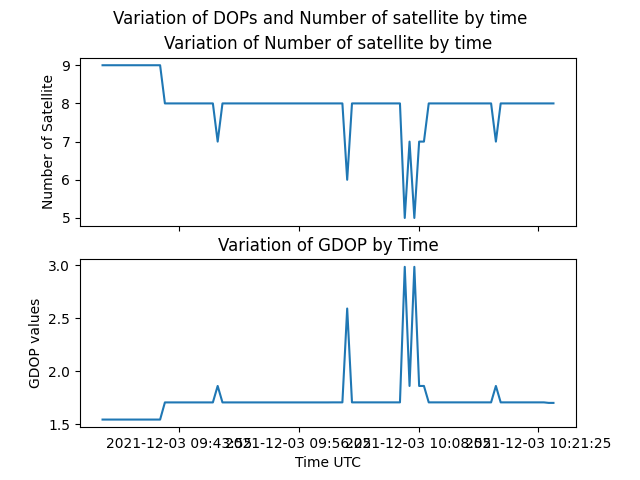

In [15]:
#Ploting GDPOP value and nb of satellite in fonction of time

fig,(ax1,ax2)=plt.subplots(2,sharex=True)
fig.suptitle('Variation of DOPs and Number of satellite by time')
ax1.plot(Gdop_to_plot['UTC_Time'],Gdop_to_plot['ns'])
locator=mdates.HourLocator(interval=60*10)
ax1.xaxis.set_major_locator(locator)
ax1.set_ylabel('Number of Satellite')
ax1.set_title('Variation of Number of satellite by time')
ax2.plot(Gdop_to_plot['UTC_Time'],Gdop_to_plot['GDOP'])
ax2.set_ylabel('GDOP values')
ax2.set_title('Variation of GDOP by Time')
ax2.set_xlabel('Time UTC')